# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Output directory for images with Mask R-CNN annotations trained on COCO
OUT_COCO_DIR = os.path.join(ROOT_DIR, "output-coco")
if not os.path.exists(OUT_COCO_DIR):
    os.mkdir(OUT_COCO_DIR)

C:\Users\vin_p\Anaconda3\envs\maskrcnn_orig_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vin_p\Anaconda3\envs\maskrcnn_orig_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vin_p\Anaconda3\envs\maskrcnn_orig_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vin_p\Anaconda3\envs\maskrcn

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection on a random image

Processing 1 images
image                    shape: (600, 371, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


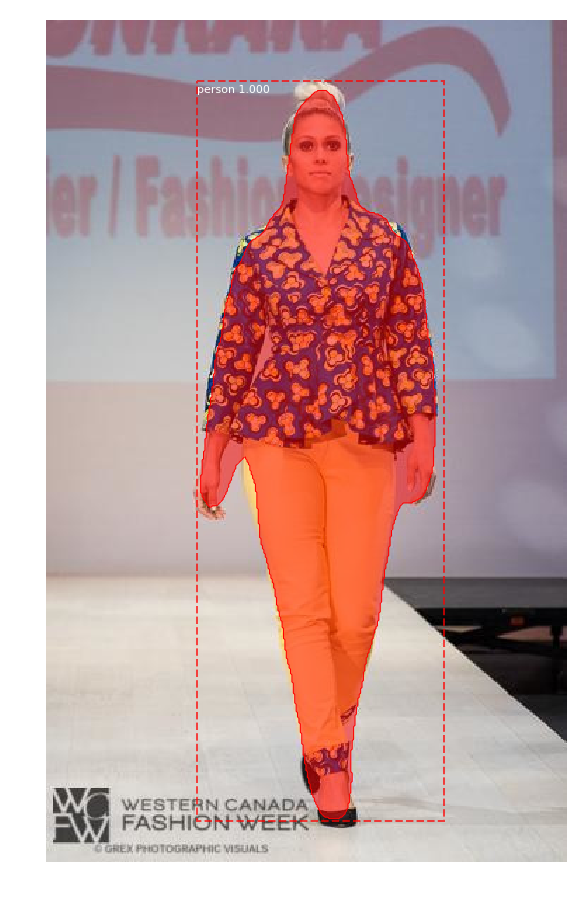

In [5]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Run Object Detection on sample images from fashion dataset and save output

In [6]:
import colorsys

# generate random (but visually distinct) colors for each class label
hsv = [(i / len(class_names), 1, 1.0) for i in range(len(class_names))]
COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
random.seed(42)
random.shuffle(COLORS)

In [7]:
# Functions inspired by: https://www.pyimagesearch.com/2019/06/10/keras-mask-r-cnn/

import cv2

def apply_masks_on_image(image, r):
    
    ''' Applies masks of each detected object in an image '''
    
    # loop over of the detected objects in the image, and apply masks
    for i in range(0, len(r["rois"])):

        # extract the class ID and mask for the current detection, then
        # grab the color to visualize the mask (in BGR format)
        mask = r["masks"][:, :, i]
        classID = r["class_ids"][i]
        color = COLORS[classID][::-1]

        # visualize the pixel-wise mask of the object
        image = visualize.apply_mask(image, mask, color, alpha=0.5)
        
    return image


def draw_bbox_and_labels_on_image(image, r):
    
    ''' Draws bounding boxes, class labels, and scores of each detected object in an image '''
    
    # convert the image back to BGR so we can use OpenCV's drawing functions
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # loop over of the detected objects in the image, and
    # draw detected objects bounding boxes and labels
    for i in range(0, len(r["rois"])):
        
        # extract the bounding box information, class ID, label, predicted
        # probability, and visualization color
        (startY, startX, endY, endX) = r["rois"][i]
        classID = r["class_ids"][i]
        color = [int(c) for c in np.array(COLORS[classID]) * 255]
        label = class_names[classID]
        score = r["scores"][i]

        # draw the bounding box, class label, and score of the object
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        text = "{}: {:.3f}".format(label, score)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
            0.6, color, 2)
        
    return image

In [8]:
# Load a image file names from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]

# loop through images
for file_name in file_names:
    
    # read image with opencv and convert to RGB for Mask R-CNN input
    image_brg = cv2.imread(os.path.join(IMAGE_DIR, file_name))
    image = cv2.cvtColor(image_brg, cv2.COLOR_BGR2RGB)
    
    # Run Mask R-CNN detection
    results = model.detect([image], verbose=1)[0]
    
    # apply masks of each detection on the image
    image = apply_masks_on_image(image, results)
        
    # draw bounding boxes, class labels, and score of each detection on the image
    image = draw_bbox_and_labels_on_image(image, results)
    
    # save output
    cv2.imwrite(os.path.join(OUT_COCO_DIR, file_name), image)

Processing 1 images
image                    shape: (1000, 618, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  132.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1280, 851, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (6016, 4016, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1